In [1]:
from dotenv import load_dotenv
import os

# Load environment variables from an .env file
load_dotenv()

True

In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
pd.set_option('display.max_rows', 100)  # You can set this to any number
pd.set_option('display.max_columns', 50)  # You can set this to any number

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def load_data_from_db(connection_string, query):
    engine = create_engine(connection_string)
    with engine.connect() as connection:
        df = pd.read_sql(query, connection)
    return df

In [4]:
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_name = os.getenv('DB_NAME')

In [5]:
connection_string = f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}/{db_name}'

In [6]:
df = load_data_from_db(connection_string, """select * from feature_set limit 500000""")

# Select cards with non-zero prices and have reached a certain dollar value

In [7]:
df = df.loc[(df.product_type == "card")]

In [8]:
# Step 1: Group by poke_id and calculate the maximum price for each poke_id
max_prices = df.groupby("poke_id")['price'].max().reset_index()

# Step 2: Filter to find poke_id's where the maximum price is 20 or less
low_price_poke_ids = max_prices[max_prices['price'] <= 20]['poke_id']

# Step 3: Remove rows from the original df where poke_id is in the low_price_poke_ids list
df = df[~df['poke_id'].isin(low_price_poke_ids)]

In [9]:
df.card_type.value_counts()
# TODO: bar plot w/ slider to filter on price (looking at card type distributions at different price points)
# Missing significant number of card types - i.e. should be far less NaNs. Need to scrape 2nd set pages of psa's website as soon as their Public API back up

card_type
NaN                          222946
full art                       1996
full art secret                 846
illustration rare               591
ultra rare                      135
special illustration rare        96
hyper rare                       96
shiny ultra rare                 66
Name: count, dtype: int64

# Some sets have no Booster box average price for that month due to early release, or only having ETB / other products
- for all sets with missing BB price for early months of release, fill with $100 (unless exceptionally high in later months, then use some backwards fill or smoothing technique)
- For sets with no BB at all, use a ETB conversion formula

In [10]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

In [11]:
mask = (df['release_date'] == df['date']) | (df['release_date'] == (df['date'] - pd.DateOffset(months=1)))

In [12]:
df.loc[mask, 'bb_mo_price_by_set'] = df.loc[mask, 'bb_mo_price_by_set'].fillna(100)

# Get aggregate, monthly prices per grade/set
- in inference, this requires average price of PSA 7-10 card for that month and set, which will likely be unavailable first few months of set release

In [13]:
avg_mo_price_by_grade_set = df.groupby(['date', 'grade', 'set_name']).agg(avg_mo_price_by_grade_set=('price','mean'))

In [14]:
df = pd.merge(df, avg_mo_price_by_grade_set, how="left", on=['date', 'grade', 'set_name'])

<Axes: >

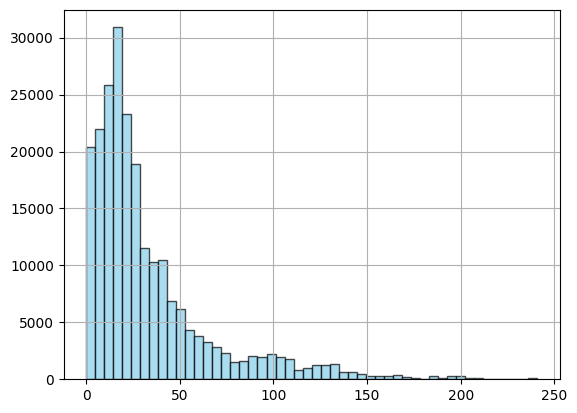

In [15]:
df.avg_mo_price_by_grade_set.loc[df.avg_mo_price_by_grade_set<500].hist(bins=50, color='skyblue', edgecolor='black', alpha=0.7)

# Combine binary features to composite features using heuristic simple logic
- iterate and optimize on these

In [16]:
#df['rarity_score'] = df[['is_secret', 'is_full_art', 'is_legendary']].sum(axis=1)
#df['popularity_score'] = df[['is_eeveelution', 'is_og_char', 'is_gallery']].sum(axis=1)
df['ir_score'] = df.apply(lambda row: 3 if row['is_sir'] else (1 if row['is_ir'] else 0), axis=1)

# Assign integer grades to all cards

In [17]:
grade_mapping = {
    'nearmint': 8,
    'psa_10': 10,
    'psa_9': 9,
    'bgs_9_half': 9.5,
    'psa_8': 8,
    'psa_7': 7
}

df['num_grade'] = df['grade'].map(grade_mapping)

# Categorize Grade

In [18]:
def categorize_grade(grade):
    if grade == 10:
        return 1  # Highest value (Grade 10)
    elif grade >= 8:
        return 2  # Middle value (Grade 8-9)
    else:
        return 3  # Lower value (below Grade 8)

df['grade_category'] = df['num_grade'].apply(categorize_grade)

In [19]:
df["grade_category"].value_counts()

grade_category
2    151495
1     37915
3     37362
Name: count, dtype: int64

# Create column is_nearmint

In [20]:
df['is_near_mint_ungraded'] = (df['grade'] == 'nearmint').astype(int)

In [21]:
df.is_near_mint_ungraded.value_counts()

is_near_mint_ungraded
0    188847
1     37925
Name: count, dtype: int64

# Create column is_tag_team

In [22]:
df['is_tag_team'] = df['poke_name'].apply(lambda x: 1 if '&' in x and not any(sub in x for sub in ['chili', 'jesse', 'liza']) else 0)

# Create column is_alt_art

- Is price charting storing pokenumber numbers like SWSH162 Correctly?

In [23]:
from modules.config import alt_arts

In [24]:
def is_alt_art(row):
    poke_name = row['poke_name']
    poke_number = row['poke_no']
    
    for short_name, number in alt_arts.items():
        if short_name in poke_name and number == str(poke_number):
            return 1 
    return 0 

# Apply the function to create the new 'is_alt_art' column
df['is_alt_art'] = df.apply(is_alt_art, axis=1)

In [25]:
unique_alt_arts = len(df.loc[df.is_alt_art==1].drop_duplicates(subset=['poke_name', 'poke_no']))
print(f"{unique_alt_arts} alt art pokemon in dataset")
df.is_alt_art.value_counts()

65 alt art pokemon in dataset


is_alt_art
0    214344
1     12428
Name: count, dtype: int64

# Create time buckets

In [26]:
def categorize_months(months):
    if months>=12 and months <=24:
        return 'between_1_2_year'
    elif months>24:
        return 'over_2_year'

df['time_bucket'] = df['mos_since_release'].apply(categorize_months).astype(str)

In [27]:
df.time_bucket.value_counts()

time_bucket
over_2_year         135559
None                 48539
between_1_2_year     42674
Name: count, dtype: int64

# OHE

In [28]:
df = pd.get_dummies(df, columns=['time_bucket'], drop_first=False)
df.loc[:, df.columns.str.startswith('time_bucket')] = df.loc[:, df.columns.str.startswith('time_bucket')].astype(int)
df.head(3)

C:\Users\huang\AppData\Local\Temp\ipykernel_22084\1363903450.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[:, df.columns.str.startswith('time_bucket')] = df.loc[:, df.columns.str.startswith('time_bucket')].astype(int)
C:\Users\huang\AppData\Local\Temp\ipykernel_22084\1363903450.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[:, df.columns.str.startswith('time_bucket')] = df.loc[:, df.columns.str.startswith('time_bucket')].astype(int)
C:\Users\huang\AppData\Local\Temp\ipykernel_22084\1363903450.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Va

,date,price,grade,poke_name,poke_no,set_name,product_type,set_year,set_month,execution_datetime,poke_id,card_type,release_date,mos_since_release,is_secret,is_full_art,is_full_art_secret,is_ir,is_sir,is_ultra_rare,is_shiny_rare,is_eeveelution,is_legendary,is_og_char,is_gallery,avg_mo_price_sealed_in_set,max_mo_price_sealed_in_set,avg_mo_price_card_in_set,max_mo_price_card_in_set,top10_nm_card_mo_sum_in_set,top10_nm_card_mo_avg_in_set,bb_mo_price_by_set,etb_mo_price_by_set,top10_mo_card_sum_to_bb_cost_ratio,avg_mo_price_psa_10_in_set,max_mo_price_psa_10_in_set,avg_mo_price_by_grade_set,ir_score,num_grade,grade_category,is_near_mint_ungraded,is_tag_team,is_alt_art,time_bucket_None,time_bucket_between_1_2_year,time_bucket_over_2_year
0,2023-12-01,16.0,bgs_9_half,counter-gain,230,lost-thunder,card,2018,11,2024-11-07 00:55:15.060212,230lost-thunder,NaN,2018-11-01,61,False,False,False,False,False,False,False,False,False,False,False,279.10,544.70,18.37,93.89,474.54,47.454,544.70,NaN,0.871195,97.41,481.55,43.446809,0,9.5,2,0,0,0,0,0,1
1,2024-01-01,18.0,bgs_9_half,counter-gain,230,lost-thunder,card,2018,11,2024-11-07 00:55:15.060212,230lost-thunder,NaN,2018-11-01,62,False,False,False,False,False,False,False,False,False,False,False,268.25,521.00,19.03,92.49,489.02,48.902,521.00,NaN,0.938618,96.25,504.96,43.297872,0,9.5,2,0,0,0,0,0,1
2,2024-02-01,18.0,bgs_9_half,counter-gain,230,lost-thunder,card,2018,11,2024-11-07 00:55:15.060212,230lost-thunder,NaN,2018-11-01,63,False,False,False,False,False,False,False,False,False,False,False,266.59,576.76,19.15,105.53,520.47,52.047,576.76,207.5,0.902403,92.51,460.00,44.127234,0,9.5,2,0,0,0,0,0,1


# Select features

In [29]:
df.columns

Index(['date', 'price', 'grade', 'poke_name', 'poke_no', 'set_name',
       'product_type', 'set_year', 'set_month', 'execution_datetime',
       'poke_id', 'card_type', 'release_date', 'mos_since_release',
       'is_secret', 'is_full_art', 'is_full_art_secret', 'is_ir', 'is_sir',
       'is_ultra_rare', 'is_shiny_rare', 'is_eeveelution', 'is_legendary',
       'is_og_char', 'is_gallery', 'avg_mo_price_sealed_in_set',
       'max_mo_price_sealed_in_set', 'avg_mo_price_card_in_set',
       'max_mo_price_card_in_set', 'top10_nm_card_mo_sum_in_set',
       'top10_nm_card_mo_avg_in_set', 'bb_mo_price_by_set',
       'etb_mo_price_by_set', 'top10_mo_card_sum_to_bb_cost_ratio',
       'avg_mo_price_psa_10_in_set', 'max_mo_price_psa_10_in_set',
       'avg_mo_price_by_grade_set', 'ir_score', 'num_grade', 'grade_category',
       'is_near_mint_ungraded', 'is_tag_team', 'is_alt_art',
       'time_bucket_None', 'time_bucket_between_1_2_year',
       'time_bucket_over_2_year'],
      dtype='obje

In [30]:
features = ["mos_since_release", 
            'num_grade',
            'is_secret', 
            'is_full_art', 
            'is_tag_team',
            'is_alt_art',
            'is_eeveelution', 
            'is_legendary',
            'is_og_char',
            'bb_mo_price_by_set', 
            'avg_mo_price_by_grade_set',
            'ir_score'
           ]

df[["poke_id"]+["poke_name"]+features+["price"]].head(3)

,poke_id,poke_name,mos_since_release,num_grade,is_secret,is_full_art,is_tag_team,is_alt_art,is_eeveelution,is_legendary,is_og_char,bb_mo_price_by_set,avg_mo_price_by_grade_set,ir_score,price
0,230lost-thunder,counter-gain,61,9.5,False,False,0,0,False,False,False,544.70,43.446809,0,16.0
1,230lost-thunder,counter-gain,62,9.5,False,False,0,0,False,False,False,521.00,43.297872,0,18.0
2,230lost-thunder,counter-gain,63,9.5,False,False,0,0,False,False,False,576.76,44.127234,0,18.0


# Corr matrix

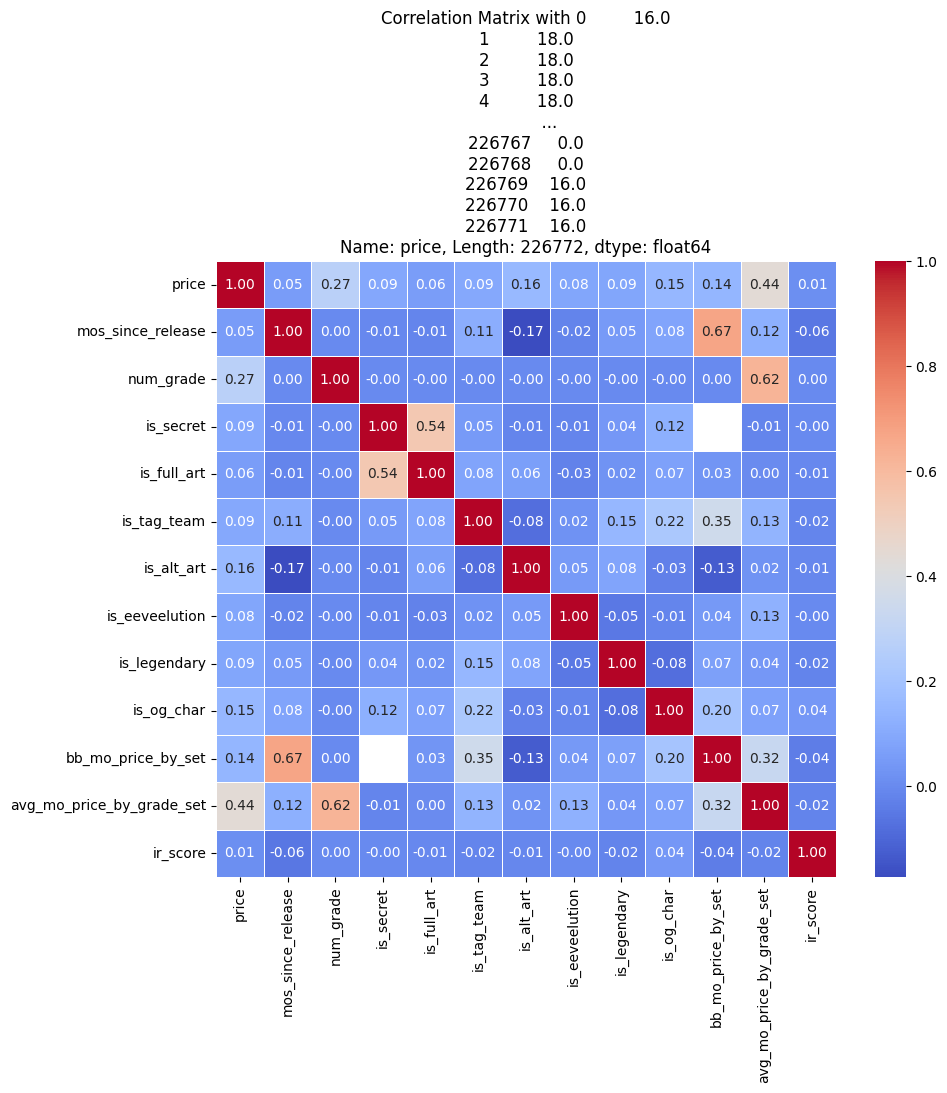

In [31]:
def plot_correlation_matrix(df, target_col):
    corr = df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(f'Correlation Matrix with {target_col}')
    plt.show()
    
plot_correlation_matrix(df[["price"]+features], df["price"])

# Train model

In [38]:
def train_xgboost_model(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', learning_rate=0.1, 
                         max_depth=5, 
                         n_estimators=250)

    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)  # RMSE (Root Mean Squared Error)
    print(f'XGBoost model RMSE: {rmse:.4f}')
    return model

In [39]:
xgb_model = train_xgboost_model(df[features], df["price"])

XGBoost model RMSE: 65.1315


C:\Users\huang\OneDrive\Desktop\projects\poke_ai\venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


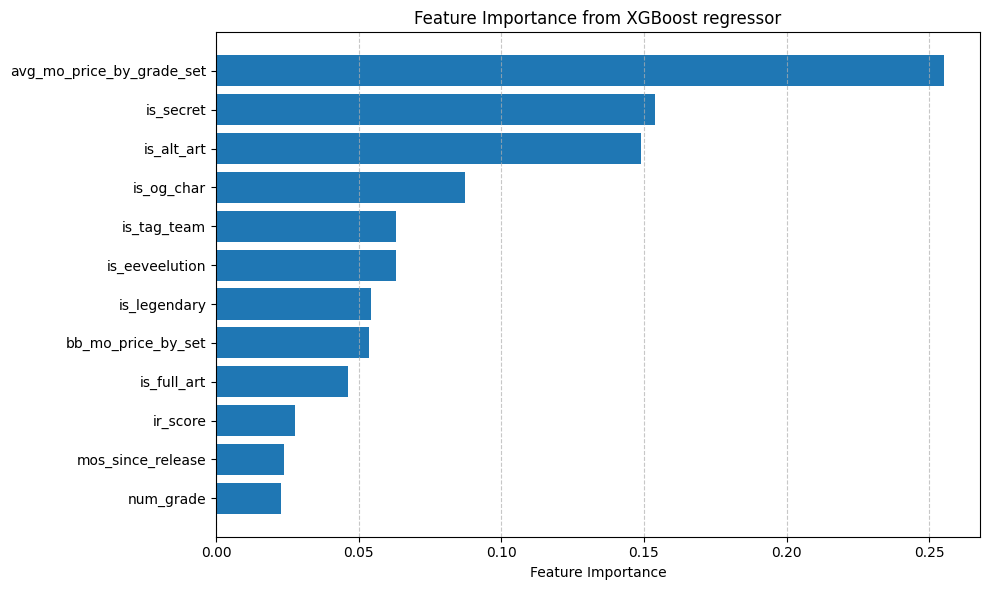

In [40]:
def plot_feature_importance(model, X):
    feature_importances = model.feature_importances_

    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
    plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
    plt.xlabel("Feature Importance")
    plt.title("Feature Importance from XGBoost regressor")
    plt.tight_layout()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

plot_feature_importance(xgb_model, df[features])

# Look at price distribution, clipped

In [71]:
clipped = df.loc[df.price<=1000]
print(clipped.price.mean())
print(df.price.mean())

32.41484197659436
33.482022648298724


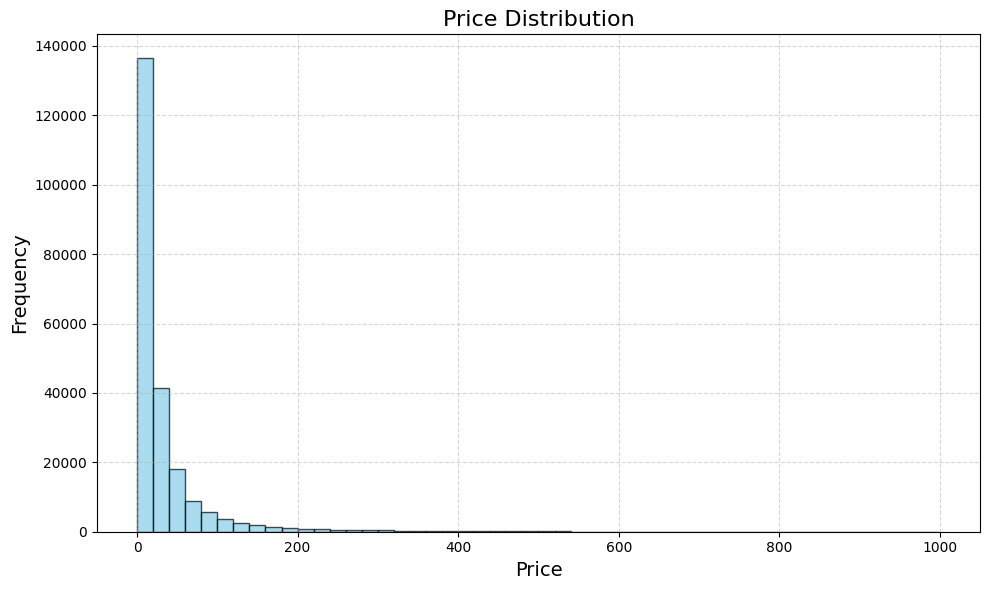

In [72]:
plt.figure(figsize=(10, 6))
plt.hist(clipped["price"], bins=50, color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Price Distribution', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()

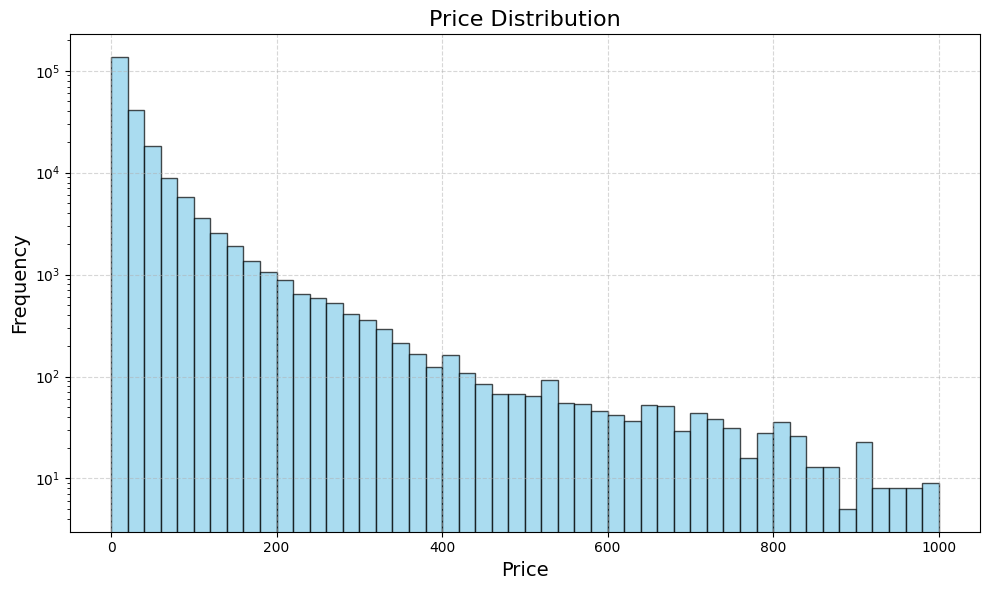

In [73]:
plt.figure(figsize=(10, 6))
plt.hist(clipped["price"], bins=50, color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Price Distribution', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.yscale("log")
plt.tight_layout()

# GridSearch + CV

In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [8,15],
    'n_estimators': [100, 200]
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse'),
                           param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(df[features], df["price"])
print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100}


In [40]:
# Best parameters and corresponding RMSE (calc from negative MSE)
print("Best parameters:", grid_search.best_params_)
best_score = np.sqrt(-grid_search.best_score_)  # Convert from negative MSE to RMSE
print("Best RMSE score:", best_score)

results = grid_search.cv_results_

results_df = pd.DataFrame(results)
results_df = results_df[['mean_test_score', 'std_test_score', 'param_learning_rate', 'param_max_depth', 'param_n_estimators']]
results_df['mean_test_rmse'] = np.sqrt(-results_df['mean_test_score'])  # Convert MSE to RMSE
results_df['std_test_rmse'] = np.sqrt(results_df['std_test_score'])  # Convert std MSE to RMSE
results_df.sort_values(by="mean_test_rmse", ascending=True).head(5)

Best parameters: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100}
Best RMSE score: 71.48919044730565


,mean_test_score,std_test_score,param_learning_rate,param_max_depth,param_n_estimators,mean_test_rmse,std_test_rmse
0,-5110.704351,1948.255154,0.01,8,100,71.489190,44.139043
1,-5406.424719,2073.402802,0.01,8,200,73.528394,45.534633
2,-5466.859008,2109.085284,0.01,15,100,73.938211,45.924779
3,-6107.548788,2276.802971,0.01,15,200,78.150808,47.715857
4,-6134.253238,2494.383480,0.10,8,100,78.321474,49.943803


# Check under/overfit with best model

In [41]:
def train_xgboost_model(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)  # RMSE (Root Mean Squared Error)
    print(f'XGBoost model RMSE: {rmse:.4f}')
    return model

learning_rate=0.01, max_depth=5 to 7, n_estimators=150

In [41]:
X_train, X_val, y_train, y_val = train_test_split(df[features], df["price"], test_size=0.2, random_state=42)


# Initialize XGBoost model with specified hyperparameters
model = xgb.XGBRegressor(objective='reg:squarederror', 
                         eval_metric='rmse',
                         learning_rate=0.1, 
                         max_depth=5, 
                         n_estimators=250)

# Fit the model to the training data
model.fit(df[features], df["price"])

# Make predictions on both training and validation sets
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Calculate RMSE for training and validation sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"Training RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"diff: {round(abs(train_rmse-val_rmse),2)}")

mean_price = df.price.mean()
std_dev = np.sqrt(df['price'].var())
print("\nMean Price is", mean_price, "with std_dev", std_dev)

Training RMSE: 59.0064
Validation RMSE: 62.7824
diff: 3.78

Mean Price is 33.482022648298724 with std_dev 77.01539077079946


# Test prediction

In [42]:
import numpy as np

def predict_card_price(model, test_features, feature_columns):
    test_features = pd.DataFrame([test_features], columns=feature_columns)
    
    predicted_price = model.predict(test_features)[0]
    
    return predicted_price

# Save TF Model

from datetime import datetime


current_datetime = datetime.now()
formatted_date = current_datetime.strftime('%m-%d-%Y')
model.save_model(f'my_model_{formatted_date}.bin')

- df['rarity_score'] = df[['is_secret', 'is_full_art', 'is_legendary']].sum(axis=1)
- df['popularity_score'] = df[['is_eeveelution', 'is_og_char', 'is_gallery']].sum(axis=1)
- df['ir_score'] = df.apply(lambda row: 3 if row['is_sir'] else (1 if row['is_ir'] else 0), axis=1)

# Formatted test payload

In [43]:
test_features = {
    "avg_mo_price_by_grade_set": 120,
    "mos_since_release": 5,
    'num_grade': 10,
    'is_secret': 0, 
    'is_alt_art': 1,
    'is_tag_team': 0,
    'is_full_art': 0, 
    'is_eeveelution': 0, 
    'is_legendary': 1,
    'is_og_char': 0,
    'ir_score': 0,
    'bb_mo_price_by_set': 222
}

predicted_price = predict_card_price(model, test_features, features)

print(f"Predicted price for the card: ${predicted_price:.2f}")

Predicted price for the card: $440.96


# How to prevent non-zero / non-negative / unrealistic price predictions? 
- give model more examples...
- handle with railguards post inference (step functions or rules to process model predictions and handle well)